<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/nice_movie_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import tensorflow as tf
import time
import numpy as np
import json
import nltk

nltk.download("popular")
print(tf.__version__)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime2.csv",sep=';', encoding='utf-8')
credits = pd.read_csv("gdrive/My Drive/TFG/tmdb_5000_credits.csv")

In [0]:
taste = taste[~taste['id'].str.contains('/')]
taste['id'] = taste['id'].astype(int)
credits['movie_id'] = credits['movie_id'].astype(int)

In [0]:
# Merge taste and credits

data = taste.merge(dataover[['id','overview']], left_on='id', right_on='id')
data = data.merge(credits[['movie_id','cast','crew']], left_on='id', right_on='movie_id')
data.drop(['movie_id'],axis=1, inplace= True)

In [7]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [8]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)
data.reset_index(inplace=True,drop=True)
len(data)

816

In [0]:
# Clean overviews ver que ocurre con deadpool y deadpool 2 

import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist() + ['secuela']

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x

def delete_stop_words(x):
    words = x.split(' ')
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [0]:
# Steaming overview

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
    stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
    return " ".join(stemmed_text)
  

In [0]:
data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))
data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

In [12]:
data.head(15)

,id,title,like,vote_average,overview,cast,crew
0,11,La guerra de las galaxias. Episodio IV: Una nu...,1,8.1,princesa leia lider movimiento rebelde desea r...,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de..."
1,12,Buscando a Nemo,1,7.6,nemo pececillo hijo unico querido protegido pa...,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de..."
2,13,Forrest Gump,1,8.2,forrest gump chico deficiencias mentales profu...,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de..."
3,22,Piratas del Caribe. La maldición de la Perla N...,1,7.5,aventurero capitan jack sparrow recorre aguas ...,"[{""cast_id"": 12, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe420fc3a36847f8000f11"", ""de..."
4,24,Kill Bill: Volumen 1,1,7.7,uma thurman asesina boda atacada miembros band...,"[{""cast_id"": 3, ""character"": ""Beatrix 'The Bri...","[{""credit_id"": ""56a517709251410c080054d2"", ""de..."
5,35,Los Simpson: La película,1,6.9,homer salvar mundo catastrofe provocado comien...,"[{""cast_id"": 2, ""character"": ""Homer / Itchy / ...","[{""credit_id"": ""52fe4211c3a36847f8001521"", ""de..."
6,58,Piratas del Caribe: El cofre del hombre muerto,1,7.0,will turner elizabeth swann casar hechos prisi...,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de..."
7,62,2001: Una odisea del espacio,1,7.9,historia humanidad diversos estadios futuro na...,"[{""cast_id"": 6, ""character"": ""Dr. Dave Bowman""...","[{""credit_id"": ""52fe4212c3a36847f8001a05"", ""de..."
8,65,8 millas,1,NaN,detroit promesa potencia industrial transform...,"[{""cast_id"": 3, ""character"": ""Jimmy B. \""Rabbi...","[{""credit_id"": ""52fe4212c3a36847f8001c6b"", ""de..."
9,70,Million Dollar Baby,1,7.7,frankie dunn entrenado representado mejores pu...,"[{""cast_id"": 4, ""character"": ""Frankie Dunn"", ""...","[{""credit_id"": ""52fe4213c3a36847f800200b"", ""de..."


In [0]:
data['overview']=data['overview'].apply(lambda x: stem_sentence(x))
data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

In [14]:
data.head(15)

,id,title,like,vote_average,overview,cast,crew
0,11,La guerra de las galaxias. Episodio IV: Una nu...,1,8.1,princes lei lid movimient rebeld dese reinstau...,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...","[{""credit_id"": ""52fe420dc3a36847f8000437"", ""de..."
1,12,Buscando a Nemo,1,7.6,nem pececill hij unic quer proteg padr captur ...,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...","[{""credit_id"": ""52fe420ec3a36847f80006b1"", ""de..."
2,13,Forrest Gump,1,8.2,forrest gump chic deficient mental profund inc...,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...","[{""credit_id"": ""52fe420ec3a36847f800076b"", ""de..."
3,22,Piratas del Caribe. La maldición de la Perla N...,1,7.5,aventurer capit jack sparrow recorr agu caribe...,"[{""cast_id"": 12, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe420fc3a36847f8000f11"", ""de..."
4,24,Kill Bill: Volumen 1,1,7.7,uma thurm asesin bod atac miembr band jef bill...,"[{""cast_id"": 3, ""character"": ""Beatrix 'The Bri...","[{""credit_id"": ""56a517709251410c080054d2"", ""de..."
5,35,Los Simpson: La película,1,6.9,hom salv mund catastrof provoc comienz hom mas...,"[{""cast_id"": 2, ""character"": ""Homer / Itchy / ...","[{""credit_id"": ""52fe4211c3a36847f8001521"", ""de..."
6,58,Piratas del Caribe: El cofre del hombre muerto,1,7.0,will turn elizabeth swann cas hech prisioner l...,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de..."
7,62,2001: Una odisea del espacio,1,7.9,histori human divers estadi futur narr pelicul...,"[{""cast_id"": 6, ""character"": ""Dr. Dave Bowman""...","[{""credit_id"": ""52fe4212c3a36847f8001a05"", ""de..."
8,65,8 millas,1,NaN,detroit promes potenci industrial transform he...,"[{""cast_id"": 3, ""character"": ""Jimmy B. \""Rabbi...","[{""credit_id"": ""52fe4212c3a36847f8001c6b"", ""de..."
9,70,Million Dollar Baby,1,7.7,franki dunn entren represent pugil regent gimn...,"[{""cast_id"": 4, ""character"": ""Frankie Dunn"", ""...","[{""credit_id"": ""52fe4213c3a36847f800200b"", ""de..."


In [0]:
# Get staff and paste to overview

def get_actors(cast):
  
  try:
    
    json_cast = json.loads(cast)
  
  except:
    
    json_cast = cast
  
  if len(json_cast) > 2:
    up = 3
  else:
    up = len(json_cast)

  actors = ''
  
  for i in range(0,up):
    actor = json_cast[i]['name']
    actor = normalize(actor.replace(' ','_').lower())
  
    actors = actors + ' ' + actor
  
  return actors

def get_director(crew):
  
  try:
    
    json_crew = json.loads(crew)
  
  except:
    
    json_crew = crew
  
  directors = [member['name'] for member in json_crew if member['job'] == 'Director']
  directors = [normalize(director.replace(' ','_').lower()) for director in directors]
  directors = str(' '.join(directors))
  
  return directors

In [0]:
data['overview']=data.apply(lambda x: get_actors(x['cast']) + ' ' + x['overview'] , axis=1)
data['overview']=data.apply(lambda x: get_director(x['crew']) + x['overview'] , axis=1)

In [17]:
data['overview'][0]

'george_lucas mark_hamill harrison_ford carrie_fisher princes lei lid movimient rebeld dese reinstaur republ galaxi tiemp omin imperi captur malevol fuerz imperial capitan implac darth vad sirvient fiel emper intrep luk skywalk ayud capit nav espacial halcon milenari android rd cpo encarg luch enemig rescat princes volv instaur justici sen galaxi'

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.1, random_state=777, stratify=y)

In [0]:
columns_train = {'Overview': overviews_train, 'Like': y_train}
train = pd.DataFrame(data=columns_train)
train.to_csv('train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'Comment': overviews_test, 'Like': y_test}
test = pd.DataFrame(data=columns_test)
test.to_csv('test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
# Embedding
num_words = 9000
maxlen = 90
embedding_size = 300

# Convolution
kernel_size = 5
filters = 300
pool_size = 2

hidden_dims = 300


# LSTM
lstm_output_size = 70

# Training
lr=0.000005
#lr=0.0001

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(overviews_train)

X_train = tokenizer.texts_to_sequences(overviews_train) 
X_test = tokenizer.texts_to_sequences(overviews_test)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(overviews_train[2]) 
print(X_train[2]) 
print(vocab_size)

john_g._avildsen ralph_macchio pat_morita william_zabka daniel laruss lleg angel procedent cost unid dispuest amig conviert blanc ataqu cobr hostil grup estudi karat comienz ali antigu novi cabecill grup situacion remedi ped ayud miyagi maestr artes marcial enseñ karat tutel miyagi daniel desarroll aptitud fisic segur necesit super obstacul
[8, 2297, 4527, 1179, 4528, 753, 4529, 158, 4530, 300, 4531, 20, 333, 997, 672, 82, 360, 4, 148, 202, 254, 754, 1180, 17, 70, 3014, 75, 149, 118, 97, 3015, 17, 209, 755, 1430, 15, 3016, 533, 2298, 2299, 301, 3014, 4532, 3016, 300, 302, 4533, 998, 134, 334, 485, 1431]
8782


In [22]:
from collections import OrderedDict

dictWords = dict(tokenizer.word_counts)

print(len(dictWords) + 1)

for k,v in list(dictWords.items()):
    if v < 2 :
        del dictWords[k]
        
print(len(dictWords) + 1) 
# Para establecer el tamaño de maxlen

len(max(X_train, key=len))

8782
4517


95

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train[1]

array([ 531, 4518,  671,  102, 1177, 3013,  605, 4519, 4520, 1427, 1776,
       4521,  752,   26, 4522,   66, 1427, 4523,  329,    7, 1178,  330,
          5,   49,  147,  331,  996,   40,  103, 4524, 2293,  280, 4525,
       1428,  330,  860,  331, 1777,  332, 4526,   63, 2294, 2295,  532,
        606,  330,  396, 1429, 2296,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [24]:
#from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

#Optimizer

from tensorflow.keras import optimizers

adam = optimizers.Adam(lr)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=30,
                   verbose=0, mode='auto')

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights

array([0.96578947, 1.03672316])

In [0]:
# Model 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='elu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 300)           2634600   
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               150500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
___________________________

In [0]:
# Model 2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D,GlobalAveragePooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length=maxlen))

model.add(Dropout(0.5))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 strides=1, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

# we use max pooling:

model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(150, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(0.5))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 90, 300)           2634600   
_________________________________________________________________
dropout_64 (Dropout)         (None, 90, 300)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 86, 300)           450300    
_________________________________________________________________
batch_normalization_v1_59 (B (None, 86, 300)           1200      
_________________________________________________________________
activation_60 (Activation)   (None, 86, 300)           0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 86, 300)           0         
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 300)               0         
__________

In [37]:
# Model 3

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input
from tensorflow.keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, Adagrad


words = Input(shape=(maxlen,))
df =  Embedding(input_dim = vocab_size, output_dim = embedding_size)(words)
c1 = Conv1D(filters = 300, kernel_size = 3, padding='valid', activation='elu', strides=1)(df)
c2 = Conv1D(filters = 300, kernel_size = 5, padding='valid', activation='elu', strides=1)(df)
c3 = Conv1D(filters = 300, kernel_size = 8, padding='valid', activation='elu', strides=1)(df)


g1 = GlobalMaxPooling1D()(c1)
g2 = GlobalMaxPooling1D()(c2)
g3 = GlobalMaxPooling1D()(c3)


pf = Concatenate(axis=1)([g1,g2,g3])
pf = Dropout(0.5)(pf) 
pred = Dense(1, activation = 'sigmoid')(pf)
model = Model(inputs=words, outputs=pred)

model.compile(optimizer = tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 90)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 90, 300)      2634600     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 88, 300)      270300      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 86, 300)      450300      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_20 

In [38]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64, class_weight = class_weights)

Train on 734 samples, validate on 82 samples
Epoch 1/10
734/734 [==============================] - 1s 1ms/sample - loss: 0.6967 - acc: 0.5218 - val_loss: 0.6905 - val_acc: 0.5732
Epoch 2/10
734/734 [==============================] - 0s 317us/sample - loss: 0.6028 - acc: 0.9564 - val_loss: 0.6831 - val_acc: 0.5122
Epoch 3/10
734/734 [==============================] - 0s 320us/sample - loss: 0.4944 - acc: 0.9959 - val_loss: 0.6647 - val_acc: 0.7195
Epoch 4/10
734/734 [==============================] - 0s 324us/sample - loss: 0.3588 - acc: 1.0000 - val_loss: 0.6248 - val_acc: 0.7195
Epoch 5/10
734/734 [==============================] - 0s 332us/sample - loss: 0.2008 - acc: 0.9986 - val_loss: 0.5648 - val_acc: 0.7683
Epoch 6/10
734/734 [==============================] - 0s 323us/sample - loss: 0.0859 - acc: 1.0000 - val_loss: 0.5162 - val_acc: 0.7683
Epoch 7/10
734/734 [==============================] - 0s 323us/sample - loss: 0.0339 - acc: 1.0000 - val_loss: 0.4847 - val_acc: 0.7683
Epoch

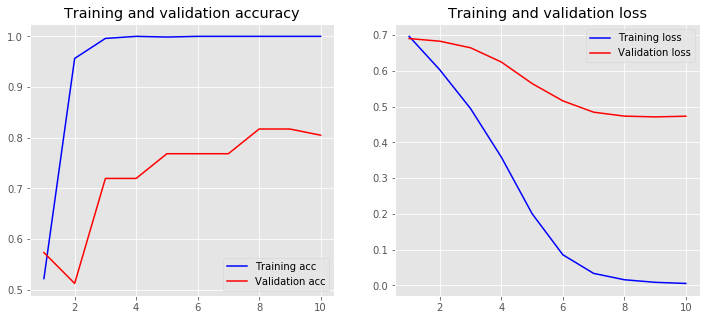

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [0]:
threshold = 0.5
y_score = model.predict(X_test)
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[34  8]
 [ 8 32]]
Accuracy: 0.8049
Kappa: 0.6095
Precision: 0.8000
Recall: 0.8000
F1: 0.8000
Auc: 0.8048


In [0]:
model.save('nice_movie' + '_model2.h5')  

In [0]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_likeness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']
    score = response['results'][0]['vote_average']
    
    id_movie = response['results'][0]['id']
    
    movie = tmdb.Movies(id_movie)
    
    actors = get_actors(movie.credits()['cast'])
    director = get_director(movie.credits()['crew'])
    
    over = clean_overview(str(over))
    over = delete_stop_words(over)

    over = actors + ' ' + over
    over = director + over
    
    print(over)
    
    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    probability = model.predict(X_over)
    print(probability)
    probability = probability[0][0] * 0.75 + (score/10)*0.25
    
    if (probability >= 0.5):
        pred = 1
        print(probability)
        if (probability < 0.5):
          probability = 0.5
        
    else:
        pred = 0
    
    return (str(pred) , str(probability), score/10)
  
  else:
    
    return 'No existe la peli'
  

In [0]:
movie = tmdb.Movies(64)
    
get_director(movie.credits()['crew'])

'pedro_almodovar'

In [0]:
get_likeness("la boda de mi mejor amiga")

{'page': 1, 'total_results': 1, 'total_pages': 1, 'results': [{'vote_count': 2682, 'id': 55721, 'video': False, 'vote_average': 6.5, 'title': 'La boda de mi mejor amiga', 'popularity': 13.59, 'poster_path': '/f5qGgjJYoG81SYAKF0VamjGrwd2.jpg', 'original_language': 'en', 'original_title': 'Bridesmaids', 'genre_ids': [35, 10749], 'backdrop_path': '/yMqCfrfz3QXGiurmXXP3pJIwKOR.jpg', 'adult': False, 'overview': 'Annie (Kristen Wiig) es una treintañera soltera del Medio Oeste, con una vida sentimental más bien precaria, a la que Lilliam, su mejor amiga (Maya Rudolph), le pide que sea su dama de honor. Sin embargo, aunque nunca ha ejercido esa función, la pobre se esfuerza por dárselas de snob en la fiesta anterior a la boda. Mientras tanto, otra amiga de Lillian (Rose Byrne) hará todo lo posible por arrebatarle el papel a la inexperta Annie', 'release_date': '2011-05-13'}]}
paul_feig kristen_wiig maya_rudolph rose_byrne annie kristen wiig treintañera soltera oeste vida sentimental precaria l

('0', '0.16622149306349457', 0.65)

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)